# Train XGBoost classifier with Final model (no. 4) and Feature Importance

## Preparation

In [1]:
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import os
print(os.getcwd())

C:\Users\NMT\OneDrive - Lancaster University\Dissertation project\Python codes\Classifications\XGBoost


Load the saved text embeddings

In [3]:
embed_filepathname1 = "../Import/SBERT_raw.csv"
text_embeddings_sep = np.genfromtxt(embed_filepathname1, delimiter=',')
data = text_embeddings_sep

emb_dim = 384
nrow = len(data)
nfeature = int(len(data[0])/emb_dim)

Load label list of model 4 (Revised labels post the cluster merging)

In [5]:
# Read the CSV file
labels = np.genfromtxt('../Import/Revised_Labels_4-WHOLE-SBERT-UMAP-HDBSCAN-None-30-35.csv', delimiter=',')

In [6]:
labels = labels.astype(int)

In [8]:
# Combine main and sub feature names
feature_names = ['{}-{}'.format(main, sub) for main in range(1, nfeature+1) for sub in range(1, emb_dim+1)]

## Split training and test data

In [9]:
from sklearn.model_selection import train_test_split
#X_filtered = reduced_embeddings[labels != -1]
X_filtered = data[labels != -1]
y_filtered = labels[labels != -1]

# Use stratify to ensure at least 2 counts in train data and 1 count in test data for each class
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)

In [11]:
pd.Series(y_train).value_counts(normalize=False)

8     48
0     38
18    22
1     17
6     14
2     12
3     12
12    11
5     10
10    10
4     10
9     10
16    10
11     8
14     6
17     5
15     5
7      5
13     3
Name: count, dtype: int64

In [12]:
pd.Series(y_test).value_counts(normalize=False)

8     21
0     16
18    10
1      7
2      6
3      6
6      6
12     5
16     4
5      4
9      4
11     4
10     4
4      4
13     2
7      2
14     2
17     2
15     2
Name: count, dtype: int64

## Main classifier training with Initial Exploration (RandomizedSearchCV)

In [36]:
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# define the model
model = XGBClassifier(objective='multi:softmax', random_state=42, importance_type='gain')

# define the parameters grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': np.arange(0.1, 1.1, 0.1),
    'n_estimators' : [100, 200, 500, 1000],
    'gamma': [0, 0.1, 0.2]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=500,  # number of parameter settings that are sampled
    scoring='accuracy',
    n_jobs=1,
    cv=2,
    verbose=3,
    random_state=42
)

# Fit RandomizedSearchCV object
#random_search.fit(X_filtered, y_filtered)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV 1/2] END colsample_bytree=0.30000000000000004, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.547 total time=   1.4s
[CV 2/2] END colsample_bytree=0.30000000000000004, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.547 total time=   1.2s
[CV 1/2] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200, subsample=0.7;, score=0.430 total time=   2.7s
[CV 2/2] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200, subsample=0.7;, score=0.414 total time=   2.6s
[CV 1/2] END colsample_bytree=0.1, gamma=0.2, learning_rate=0.05, max_depth=9, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.570 total time=   0.6s
[CV 2/2] END colsample_bytree=0.1, gamma=0.2, learning_rate=0.05, max_depth=9, min_child

In [37]:
best_params

{'subsample': 0.5,
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.30000000000000004}

### Obtain best CV score = accuracy of training data

In [38]:
random_search.best_score_

0.6328125

### Obtain accuracy of test data

In [39]:
from sklearn.metrics import accuracy_score, classification_report

# Assume you already have a train-test split data:
# X_train, X_test, y_train, y_test

# Get the best estimator from RandomizedSearchCV
best_xgb = random_search.best_estimator_

# Predict the labels of the test set
y_pred = best_xgb.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of the XGBoost model after hyperparameter tuning is: {accuracy}')
# print classification report
#print(classification_report(y_test, y_pred))

The accuracy of the XGBoost model after hyperparameter tuning is: 0.6936936936936937


## Refined Search with Cross Validation (GridSearchCV)

In [51]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# define the model
#model = XGBClassifier(objective='multi:softmax', num_class=int(max(labels)+1), random_state=42)  # adjust num_class accordingly
model = XGBClassifier(objective='multi:softmax', random_state=42, importance_type='gain', n_estimators=1000)

# define the parameters grid
param_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 2],
    'subsample': [0.4, 0.5, 0.6],
    'colsample_bytree': [0.2, 0.3, 0.4],
    'gamma': [0.05, 0.1, 0.15]
}

# set up the grid search
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=2)  # adjust cv as needed

# execute the grid search
#grid_search.fit(X_train, y_train)

#cv = KFold(5)  # cross-validation generator for model selection

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    cv=2,
    verbose=4
)

# Fit RandomizedSearchCV object
#random_search.fit(X_filtered, y_filtered)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_final = grid_search.best_params_

Fitting 2 folds for each of 486 candidates, totalling 972 fits
[CV 1/2] END colsample_bytree=0.2, gamma=0.05, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.4;, score=0.617 total time=   8.0s
[CV 2/2] END colsample_bytree=0.2, gamma=0.05, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.4;, score=0.656 total time=   8.1s
[CV 1/2] END colsample_bytree=0.2, gamma=0.05, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.5;, score=0.586 total time=   8.5s
[CV 2/2] END colsample_bytree=0.2, gamma=0.05, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.5;, score=0.656 total time=   8.6s
[CV 1/2] END colsample_bytree=0.2, gamma=0.05, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.602 total time=   8.3s
[CV 2/2] END colsample_bytree=0.2, gamma=0.05, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.6;, score=0.625 total time=   8.4s
[CV 1/2] END colsample_bytree=0.2, gamma=0.05, learning

In [52]:
best_params_final

{'colsample_bytree': 0.2,
 'gamma': 0.05,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.5}

In [53]:
grid_search.best_score_

0.6484375

In [56]:
from sklearn.metrics import accuracy_score, classification_report

# Get the best estimator from GridSearchCV
best_xgb_final = grid_search.best_estimator_

# Predict the labels of the test set
y_pred_final = best_xgb_final.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_final)

print(f'The accuracy of the XGBoost model after hyperparameter tuning is: {accuracy}')
# print classification report
#print(classification_report(y_test, y_pred))

The accuracy of the XGBoost model after hyperparameter tuning is: 0.7207207207207207


## Feature Importance with Built-in method

In [67]:
# Get feature importance
#importance = np.array(list(best_xgb.get_booster().get_score(importance_type='gain').values()))
importance = best_xgb_final.feature_importances_


# Print feature importance
#for i, score in enumerate(importance.values()):
#    print('Feature %d: %s, Score: %.5f' % (i, feature_names[i], score))

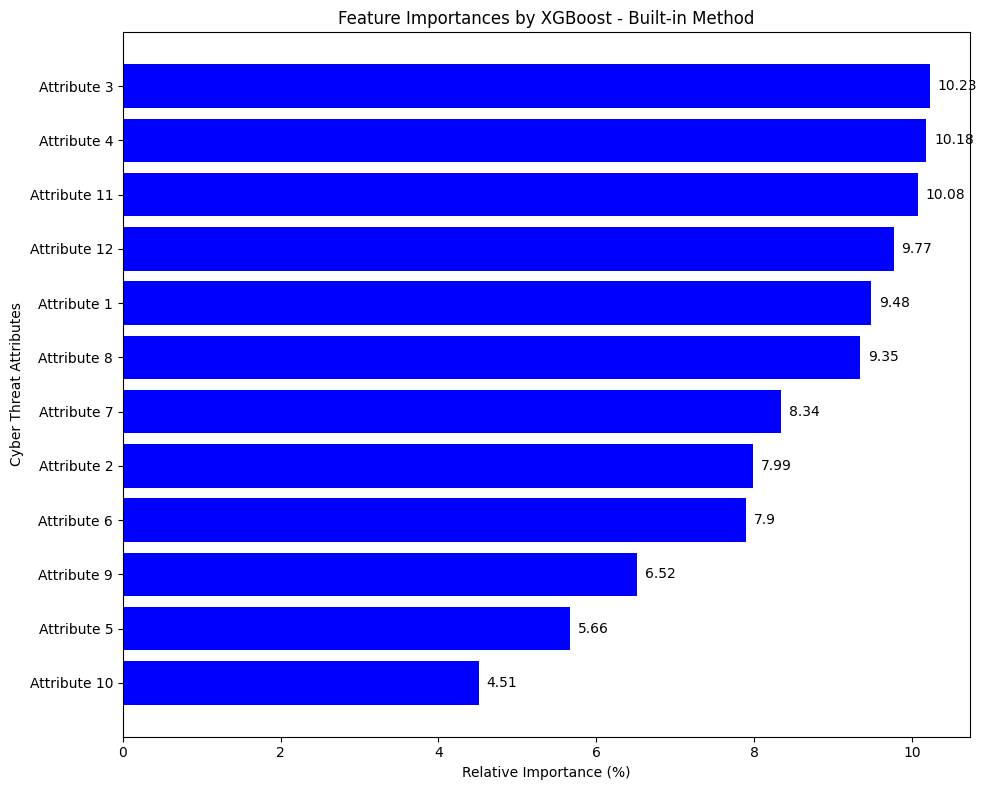

In [68]:
import matplotlib.pyplot as plt

feature_importance_main =  np.array([np.sum(importance[main*emb_dim:(main+1)*emb_dim]) for main in range(nfeature)])

# Normalize the importances so they sum to 1 (or 100%)
feature_importances_percentage = (feature_importance_main / feature_importance_main.sum()) * 100

# Sort the importances in descending order
sorted_indices = np.argsort(feature_importances_percentage)
sorted_importances = feature_importances_percentage[sorted_indices]

# Corresponding main feature labels (1 to 12)
features = [f"Attribute {i}" for i in range(1, nfeature+1)]
sorted_features = [features[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_features, sorted_importances, color='blue')

# Add values next to the bars
for bar in bars:
    xval = bar.get_width()  # Get the width of the bar (its length)
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 2), 
             ha='left', va='center')  # Adjust horizontal position after the bar

plt.ylabel("Cyber Threat Attributes")
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importances by XGBoost - Built-in Method")
plt.tight_layout()

# Save the plot
plt.savefig('Feature Importances by XGBoost - Built-in Method.png', dpi=300, bbox_inches='tight')

plt.show()

(For reference only) XGBoost built-in feature importance plot

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

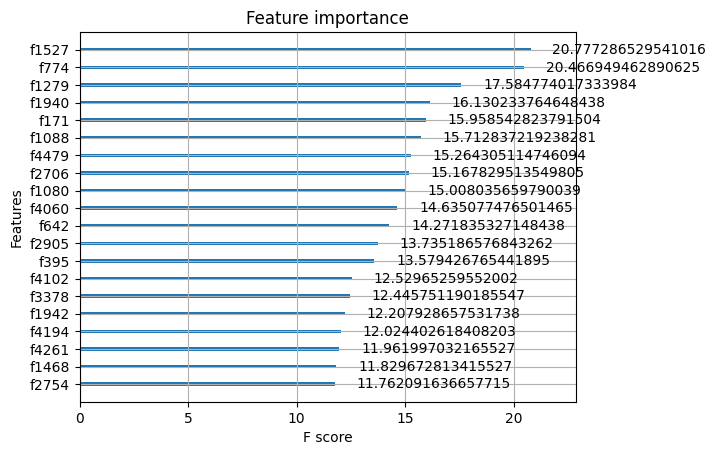

In [59]:
from xgboost import plot_importance

#xgb.plot_importance(model,max_num_features=10,importance_type = "weight")
plot_importance(best_xgb_final, importance_type='gain', max_num_features=20)

## Feature Importance with external method - SHAP

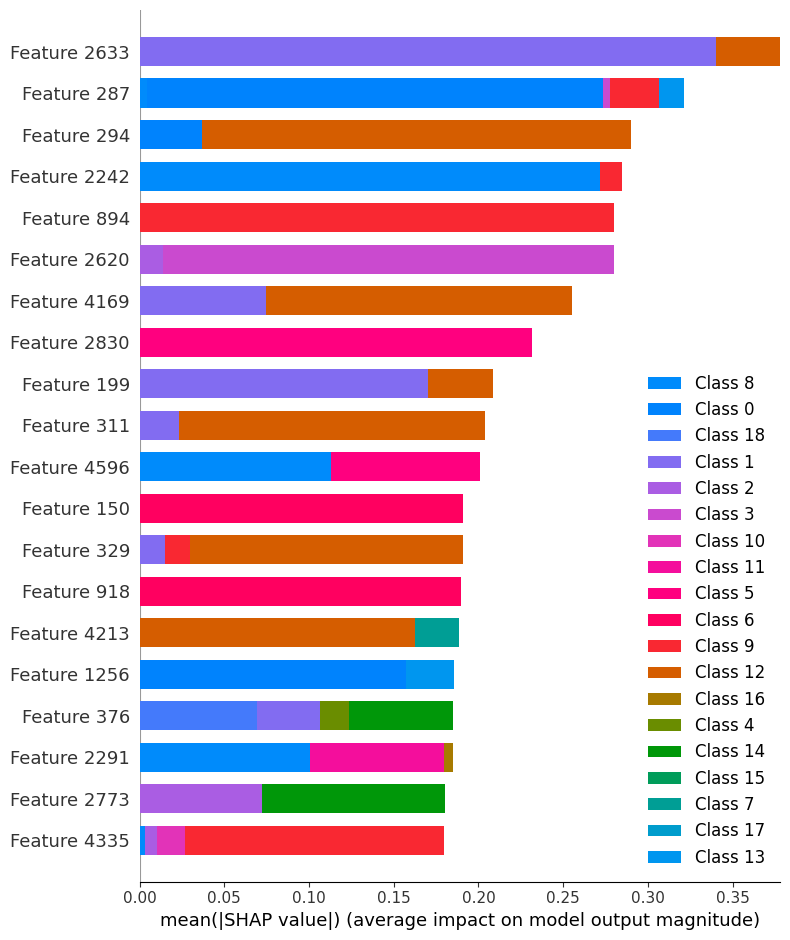

In [60]:
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_xgb_final)
#explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_test)

# built-in summary plot the SHAP values (for reference only)
#shap.summary_plot(shap_values, X_test, feature_names=iris.feature_names)
shap.summary_plot(shap_values, X_test)



In [61]:
# for multi-class classification, you can sum the absolute SHAP values over all classes
feature_importance = np.sum(np.abs(shap_values), axis=0).mean(0)

In [62]:
# Further sum the SHAP values for all threat attributes
feature_importance_main =  np.array([np.sum(feature_importance[main*emb_dim:(main+1)*emb_dim]) for main in range(nfeature)])

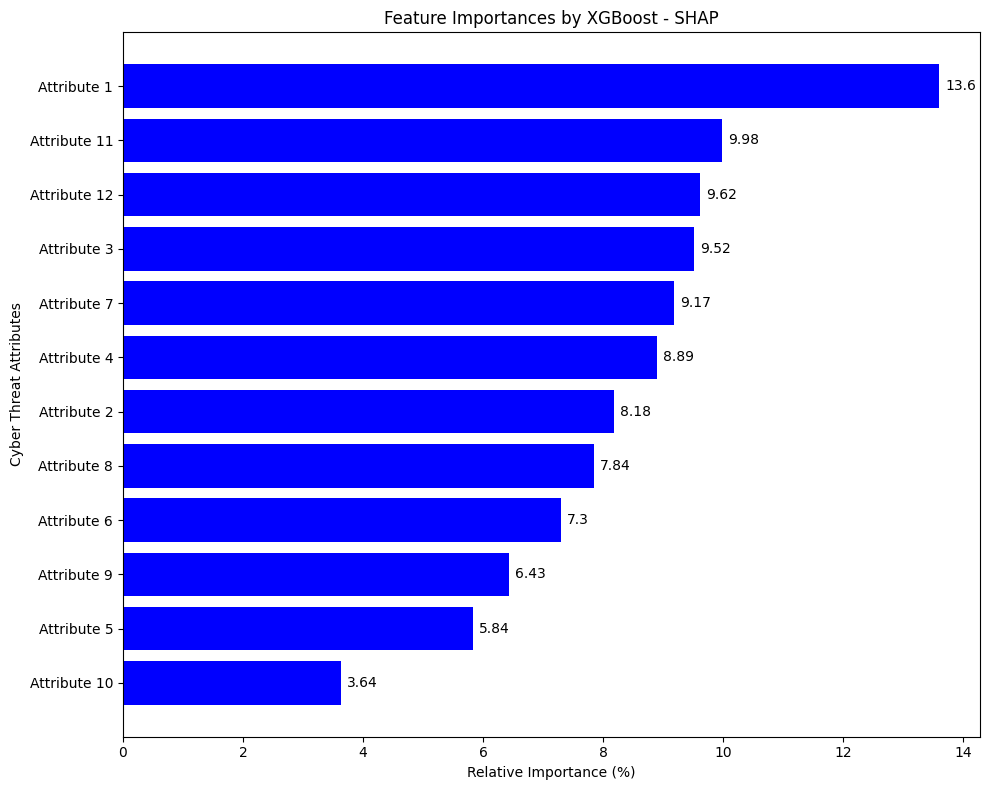

In [66]:
import matplotlib.pyplot as plt

# Normalize the importances so they sum to 1 (or 100%)
feature_importances_percentage = (feature_importance_main / feature_importance_main.sum()) * 100

# Sort the importances in descending order
sorted_indices = np.argsort(feature_importances_percentage)
sorted_importances = feature_importances_percentage[sorted_indices]

# Corresponding main feature labels (1 to 12)
features = [f"Attribute {i}" for i in range(1, nfeature+1)]
sorted_features = [features[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_features, sorted_importances, color='blue')

# Add values next to the bars
for bar in bars:
    xval = bar.get_width()  # Get the width of the bar (its length)
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 2), 
             ha='left', va='center')  # Adjust horizontal position after the bar

plt.ylabel("Cyber Threat Attributes")
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importances by XGBoost - SHAP")
plt.tight_layout()

# Save the plot
plt.savefig('Feature Importances by XGBoost - SHAP.png', dpi=300, bbox_inches='tight')

plt.show()